In [1]:
import pandas as pd
import numpy as np
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
import io

# Step 1: Setup
role = get_execution_role()
region = boto3.session.Session().region_name
session = sagemaker.Session()
bucket = "cardiovale-solutions-datascience-pipeline"
train_key = "xgb/manual/train/train.csv"

# Step 2: Load data with extreme validation
s3_client = boto3.client("s3")
source_key = "feature-store/cardio/cardio-feature-group-22-21-14-34/autopilot_input.csv"
response = s3_client.get_object(Bucket=bucket, Key=source_key)
df = pd.read_csv(response["Body"])

# Step 3: Nuclear option for label cleaning
print("Original label distribution:")
print(df["cardio"].value_counts())

# Convert to numeric, drop NA, then force binary
df["cardio"] = pd.to_numeric(df["cardio"], errors="coerce")
df = df.dropna(subset=["cardio"])
df["cardio"] = np.where(df["cardio"] > 0.5, 1, 0).astype(int) 

# Final validation
assert set(df["cardio"].unique()) == {0, 1}, f"Invalid labels found: {df['cardio'].unique()}"
print("Final label distribution:")
print(df["cardio"].value_counts())

# Step 4: Prepare features
df = df.select_dtypes(include=[np.number])
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Step 5: Move label to last position
label_col = "cardio"
cols = [c for c in df.columns if c != label_col] + [label_col]
df = df[cols]

# Ensure label is the first column (required for CSV with no header)
label_col = "cardio"
cols = [label_col] + [col for col in df.columns if col != label_col]
df = df[cols]

# Step 6: Create train/test split
train_df = df.sample(frac=0.7, random_state=42)
test_df = df.drop(train_df.index)
print(f"Split complete - Train: {train_df.shape}, Test: {test_df.shape}")

# Step 7: Save to CSV with explicit formatting
csv_buffer = io.StringIO()
train_df.to_csv(csv_buffer, index=False, header=False, float_format="%.6f")
csv_content = csv_buffer.getvalue()

# Verify the last column
last_col_vals = [row.split(",")[-1].strip() for row in csv_content.split("\n") if row]
print(f"Last column sample values: {set(last_col_vals[:100])}")

# Upload with proper content type
s3_client.put_object(
    Bucket=bucket,
    Key=train_key,
    Body=csv_content,
    ContentType="text/csv"
)

# Step 8: Configure training
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-2")  

xgb_estimator = Estimator(
    image_uri=xgboost_container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{bucket}/xgb/manual/output/",
    sagemaker_session=session,
    base_job_name="cardio-xgboost-final"
)

# Simplified hyperparameters
xgb_estimator.set_hyperparameters(
    objective="binary:logistic",
    num_round=50,
    eval_metric="error",
    verbosity=2  # Increased logging
)

# Step 9: Train with File mode
print("Starting training with verified data...")
xgb_estimator.fit(
    {"train": TrainingInput(
        f"s3://{bucket}/{train_key}",
        content_type="text/csv",
        input_mode="File",
        distribution="ShardedByS3Key"  # Better for large files
    )},
    wait=True,
    logs=True
)

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Original label distribution:
cardio
0    35021
1    34979
Name: count, dtype: int64
Final label distribution:
cardio
0    35021
1    34979
Name: count, dtype: int64
Split complete - Train: (49000, 16), Test: (21000, 16)
Last column sample values: {'2.000000', '0.000000'}


[04/05/25 21:28:17] INFO     Ignoring unnecessary instance type: None.                            ]8;id=265285;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=899112;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

Starting training with verified data...


                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=650206;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=866570;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=881462;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=976207;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             cardio-xgboost-final-2025-04-05-21-28-17-356                                          

2025-04-05 21:28:18 Starting - Starting the training job...
..25-04-05 21:28:32 Starting - Preparing the instances for training.
..25-04-05 21:28:56 Downloading - Downloading input data.
.....04-05 21:29:42 Downloading - Downloading the training image.
2025-04-05 21:30:43 Training - Training image download completed. Training in progress.
[2025-04-05 21:30:37.387 ip-10-0-107-229.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-04-05:21:30:37:INFO] Imported framework sagemaker_xgboost_container.training
[2025-04-05:21:30:37:INFO] Failed to parse hyperparameter eval_metric value error to Json.
Returning the value itself
[2025-04-05:21:30:37:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2025-04-05:21:30:37:INFO] No GPUs detected (normal if no gpus installed)
[2025-04-05:21:30:37:INFO] Running XGBoost Sagemaker in algorithm mode
[2025-04-05:21:30:37:INFO] Determined delimiter of CSV input is ','
[2025-04-

In [7]:
# Deploy the trained model
predictor = xgb_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)


[04/05/25 21:38:13] INFO     Creating model with name: cardio-xgboost-final-2025-04-05-21-38-13-629 ]8;id=471768;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=432771;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/05/25 21:38:14] INFO     Creating endpoint-config with name                                     ]8;id=488371;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=109401;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#6019\6019]8;;\
                             cardio-xgboost-final-2025-04-05-21-38-13-629                                          

                    INFO     Creating endpoint with name                                            ]8;id=959729;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=855657;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4841\4841]8;;\
                             cardio-xgboost-final-2025-04-05-21-38-13-629                                          

------!

# Prepare test data

In [11]:
import numpy as np
import json
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Remove the label column from test set
X_test = test_df.drop("cardio", axis=1)
y_true = test_df["cardio"].values  # Save the true labels

# Step 2: Convert to CSV payload
import io
csv_buffer = io.StringIO()
X_test.to_csv(csv_buffer, header=False, index=False)
csv_payload = csv_buffer.getvalue()


# Predict Using the Endpoint

In [12]:
# Predict using the endpoint
response = predictor.predict(csv_payload, initial_args={"ContentType": "text/csv"})


# Step 4: Convert prediction response to binary class labels


In [14]:
# Step 4: Decode and parse line-by-line
decoded_response = response.decode("utf-8") if hasattr(response, "decode") else response
y_prob = [float(x) for x in decoded_response.strip().split("\n")]

# Convert probabilities to binary labels
y_pred = [int(round(p)) for p in y_prob]

# Evaluate with Confusion Matrix and Metrics

In [15]:
# Step 5: Evaluate
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_true, y_pred))


Confusion Matrix:
 [[8117 2411]
 [3219 7253]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74     10528
           1       0.75      0.69      0.72     10472

    accuracy                           0.73     21000
   macro avg       0.73      0.73      0.73     21000
weighted avg       0.73      0.73      0.73     21000



# Visualize the Confusion Matrix

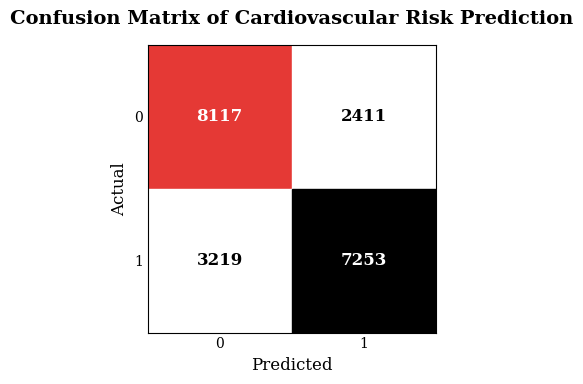

In [18]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix values (use your actual values here)
cm = np.array([[8117, 2411],
               [3219, 7253]])

# Label map
labels = np.array([["TP", "FP"], ["FN", "TN"]])  # optional, not printed

# Color map manual
square_colors = np.array([["#E53935", "#FFFFFF"],  # Red, White
                          ["#FFFFFF", "#000000"]])  # White, Black

# Set font and layout style
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

# Save directory
save_dir = "../images" if os.path.exists("../images") else "images"
os.makedirs(save_dir, exist_ok=True)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot each cell manually
for i in range(2):
    for j in range(2):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=square_colors[i, j]))
        ax.text(j + 0.5, i + 0.5, f"{cm[i, j]}", va='center', ha='center',
                color='white' if square_colors[i, j] == "#000000" or square_colors[i, j] == "#E53935" else 'black',
                fontsize=12, fontweight='bold')

# Set ticks
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(["0", "1"])
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(["0", "1"])

# Labels
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix of Cardiovascular Risk Prediction", fontsize=14, fontweight='bold', pad=15)

# Aesthetics
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "confusion_matrix_custom.png"), dpi=300, bbox_inches='tight')
plt.show()


# Realease Resources

In [19]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}